In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.bag as db
import dask.dataframe as dd
import string
import json
import pyjq
from dask import delayed
import os

from collections import Counter
import dask.array as da
from dask.distributed import Client, LocalCluster
#remove stopwords
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from string import digits 
from itertools import combinations_with_replacement
import time
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/mariam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [2]:
from dask.distributed import Client, progress
client = Client('172.16.1.104:8786')
client

Client Scheduler: tcp://172.16.1.104:8786 Dashboard: http://172.16.1.104:8787/status,Cluster Workers: 7 Cores: 49 Memory: 50.35 GB


#**Filtering json files using jq**
#**The input to jq is parsed as a sequence of whitespace-separated JSON values**
#**which are passed through the provided filter one at a time.**
#**The output(s) of the filter are written to standard out**
#**again as a sequence of whitespace-separated JSON data.**

In [5]:
# %%time

# %%bash
# mkdir -p data/new_papers
# cd data/papers_in_json
# for filename in *.json; do
#     echo $filename
#     jq -c . $filename > ../new_papers/$filename
# done

In [24]:
%%time
papers_bag = db.read_text('data/new_papers/*.json').map(json.loads).repartition(npartitions=2)

CPU times: user 288 ms, sys: 28.3 ms, total: 316 ms
Wall time: 308 ms


In [7]:
%%time
papers_bag.take(1)

CPU times: user 381 ms, sys: 13.8 ms, total: 394 ms
Wall time: 7.11 s


({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'metadata': {'title': 'PfSWIB, a potential chromatin regulator for var gene regulation and parasite development in Plasmodium falciparum',
   'authors': [{'first': 'Wei-Feng',
     'middle': [],
     'last': 'Wang',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'Second Military Medical University',
      'location': {'postCode': '200433',
       'settlement': 'Shanghai',
       'country': 'China'}},
     'email': ''},
    {'first': 'Yi-Long',
     'middle': [],
     'last': 'Zhang',
     'suffix': '',
     'affiliation': {'laboratory': '',
      'institution': 'Second Military Medical University',
      'location': {'postCode': '200433',
       'settlement': 'Shanghai',
       'country': 'China'}},
     'email': ''}]},
  'abstract': [{'text': 'Background: Various transcription factors are involved in the process of mutually exclusive expression and clonal variation of the Plasmodium multigene (

In [4]:
#Commented part if all words in the document needed not just body_text
def flat_bag(record):
    full_text={}
    keys=record.keys()
#     text=[record[key] for key in keys]
    text=record['body_text']
    full_text[record['paper_id']]=text
    return full_text

In [9]:
%%time
text=papers_bag.map(flat_bag)

CPU times: user 742 µs, sys: 108 µs, total: 850 µs
Wall time: 856 µs


In [10]:
%%time
text.take(1)

CPU times: user 229 ms, sys: 2.53 ms, total: 232 ms
Wall time: 6.72 s


({'000a0fc8bbef80410199e690191dc3076a290117': [{'text': 'Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mech

**CLEANING THE TEXT**

In [5]:
def text_cleaner(text):
    def remove_nums(arr): 
        remove_digits = str.maketrans('', '', digits) 
        arr = [i.translate(remove_digits) for i in arr] 
        return arr
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    clean_dict={}
    paper_id=list(text.keys())[0]
    values=list(text.values())
    tokenized = tokenizer.tokenize(str(values))
    tokenized=remove_nums(tokenized)
    words=str(tokenized).translate(str.maketrans('', '', string.punctuation)).lower().split()
    clean_text=[w for w in words if w not in stop_words]
    clean_dict[paper_id]=clean_text
    return clean_dict

In [12]:
%%time
clean_dicts=text.map(text_cleaner)

CPU times: user 5.08 ms, sys: 138 µs, total: 5.22 ms
Wall time: 5.57 ms


# 3.1.1 MAP

**COUNTING WORDS OF EACH PAPER >> MAP**

$(w, cp(w))$ 
FOR $w$ $\in$ $D_{i}$ ;
where $cp(w)$ is the frequency of words in a document.


In [6]:
def word_count(clean_record):
    counts = dict()
    all_counts=dict()
    paper_id=list(clean_record.keys())[0]
    words=list(clean_record.values())[0]
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    all_counts[paper_id]=counts
    return all_counts

In [14]:
%%time
papers_counts=clean_dicts.map(word_count)

CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 1.83 ms


In [15]:
%%time
papers_counts.take(10)

CPU times: user 338 ms, sys: 10.1 ms, total: 348 ms
Wall time: 7.71 s


({'000a0fc8bbef80410199e690191dc3076a290117': {'text': 198,
   'plasmodium': 7,
   'falciparum': 29,
   'causes': 2,
   'malignant': 1,
   'malaria': 6,
   'cerebral': 1,
   'cm': 1,
   'pregnancy': 1,
   'associated': 5,
   'pam': 1,
   'cause': 1,
   'death': 1,
   'individuals': 1,
   'annually': 1,
   'erythrocyte': 1,
   'membrane': 1,
   'protein': 21,
   'pfemp': 3,
   'encoded': 2,
   'var': 64,
   'gene': 42,
   'family': 7,
   'comprising': 2,
   'approximately': 3,
   'members': 4,
   'major': 5,
   'virulence': 3,
   'factor': 2,
   'involved': 9,
   'antigenic': 3,
   'variation': 7,
   'clinical': 1,
   'pathogenicity': 1,
   'remarkable': 1,
   'expression': 44,
   'mutually': 7,
   'exclusive': 7,
   'parasite': 35,
   'time': 7,
   'one': 8,
   'genes': 40,
   'expressed': 12,
   'remaining': 1,
   'silenced': 1,
   'generation': 1,
   'p': 47,
   'able': 1,
   'express': 1,
   'different': 12,
   'switches': 1,
   'lead': 3,
   'results': 13,
   'immune': 2,
   'evasi

# 3.1.2 Reduce

**COUNTING WORDS OF EACH PAPER >> REDUCE**

$(w, c(w))$ 

$c(w)=\sum_{k=1}^n cp_{k}(w)$, $n= 1000$, number of Documents

In [7]:
def text_cleaner2(text):
    def remove_nums(arr): 
        remove_digits = str.maketrans('', '', digits) 
        arr = [i.translate(remove_digits) for i in arr] 
        return arr
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    clean_dict={}
#     paper_id=list(text.keys())[0]
    values=list(text.values())
    tokenized = tokenizer.tokenize(str(values))
    tokenized=remove_nums(tokenized)
    words=str(tokenized).translate(str.maketrans('', '', string.punctuation)).lower().split()
    clean_text=[w for w in words if w not in stop_words]
#     clean_dict[paper_id]=clean_text
    return clean_text

In [17]:
all_clean_text=text.map(text_cleaner2)

In [8]:
def add(x, y):
    return x + y

In [19]:
%%time
full_bag=db.from_sequence(all_clean_text.fold(add).compute())
all_counts=full_bag.frequencies().compute()

CPU times: user 11.8 s, sys: 318 ms, total: 12.1 s
Wall time: 1min 36s


In [20]:
all_counts

[('text', 108932),
 ('plasmodium', 61),
 ('falciparum', 73),
 ('causes', 789),
 ('malignant', 187),
 ('malaria', 238),
 ('cerebral', 432),
 ('cm', 498),
 ('pregnancy', 249),
 ('associated', 3961),
 ('pam', 21),
 ('cause', 1404),
 ('death', 1180),
 ('individuals', 1413),
 ('annually', 68),
 ('erythrocyte', 35),
 ('membrane', 1353),
 ('protein', 5924),
 ('pfemp', 3),
 ('encoded', 362),
 ('var', 72),
 ('gene', 3283),
 ('family', 1109),
 ('comprising', 113),
 ('approximately', 780),
 ('members', 695),
 ('major', 1682),
 ('virulence', 303),
 ('factor', 1470),
 ('involved', 1440),
 ('antigenic', 316),
 ('variation', 453),
 ('clinical', 4949),
 ('pathogenicity', 114),
 ('remarkable', 119),
 ('expression', 3976),
 ('mutually', 46),
 ('exclusive', 72),
 ('parasite', 318),
 ('time', 5713),
 ('one', 6093),
 ('genes', 2335),
 ('expressed', 1292),
 ('remaining', 385),
 ('silenced', 11),
 ('generation', 580),
 ('p', 6993),
 ('able', 1011),
 ('express', 366),
 ('different', 4767),
 ('switches', 29),


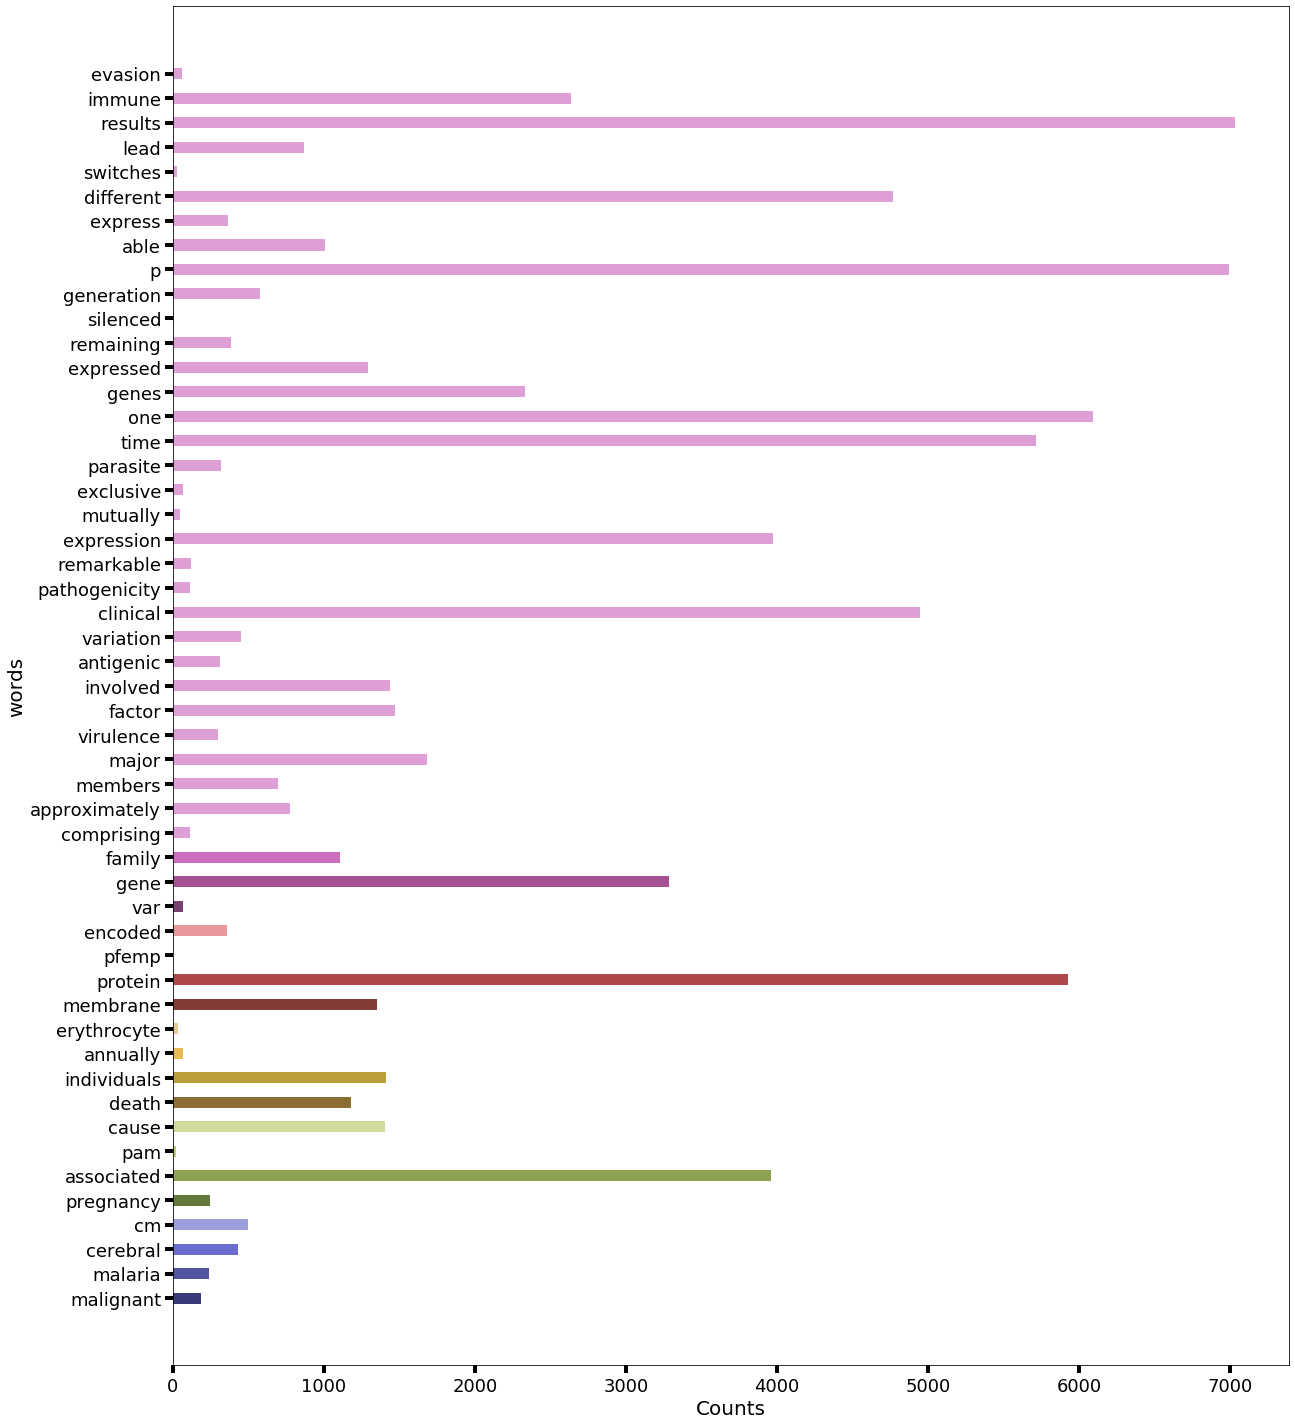

In [40]:
import numpy as np
import matplotlib.pyplot as plt


data = all_counts[4:55]
names, values = zip(*data)  # @comment by Matthias
# names = [x[0] for x in data]  # These two lines are equivalent to the the zip-command.
# values = [x[1] for x in data] # These two lines are equivalent to the the zip-command.

y_pos = np.arange(len(names))  # the x locations for the groups
width = 0.45       # the width of the bars

fig,ax=plt.subplots(figsize=(20,25))
fig.suptitle=('Words Frequencies')
rects1 = ax.barh(y_pos,values, width, color=plt.cm.tab20b(np.arange(len(data))))
# add some text for labels, title and axes ticks0
ax.set_ylabel('words', fontsize=20)
ax.set_xlabel('Counts',  fontsize=20)
ax.set_yticks(y_pos)
ax.tick_params(axis='both',direction='out', length=8,labelsize=18, width=4, colors='black')

ax.set_yticklabels(names)



# def autolabel(rects):
#     # attach some text labels
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%d' % int(height),
#                 ha='center', va='bottom')

# autolabel(rects1)

plt.show()


# 3.2  The Most Contributing Countries

**TRIAL ONE**

In [25]:
authors=papers_bag.pluck('metadata').pluck('authors')

In [9]:
def flat_authors(auth_rec):
    first_name=''
    last_name=''
    univ=''
    country=''
    if type(auth_rec)==list and len(auth_rec)>1:
        first_name=auth_rec[0]['first']
        last_name=auth_rec[0]['last']
        if 'institution' in list(auth_rec[0]['affiliation'].keys()):
            univ=auth_rec[0]['affiliation']['institution']
        else: univ='empty'
        if 'location' in list(auth_rec[0]['affiliation'].keys()):
            if 'country' in list(auth_rec[0]['affiliation']['location'].keys()):
                country=auth_rec[0]['affiliation']['location']['country']
            else:country='empty'        
    elif type(auth_rec)==dict:
        first_name=auth_rec['first']
        last_name=auth_rec['last']
        if 'institution' in list(auth_rec['affiliation'].keys()):
            univ=auth_rec['affiliation']['institution']
        else: univ='empty'
        if 'location' in list(auth_rec['affiliation'].keys()):
            if 'country' in list(auth_rec['affiliation']['location'].keys()):
                country=auth_rec['affiliation']['location']['country']
            else:country='empty'
    info={'first_name':first_name,
          'last_name':last_name,
          'institution':univ,
          'country':country}
    return info

In [330]:
%%time
auth_info=authors.map(flat_authors)

CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 2.88 ms


In [331]:
auth_info.take(1)

({'first_name': 'Wei-Feng',
  'last_name': 'Wang',
  'institution': 'Second Military Medical University',
  'country': 'China'},)

In [332]:
%%time
auth_dd=auth_info.to_dataframe()

CPU times: user 557 ms, sys: 14.5 ms, total: 572 ms
Wall time: 9.7 s


In [333]:
%%time
auth_dd.head()

CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 9.6 s


,first_name,last_name,institution,country
0,Wei-Feng,Wang,Second Military Medical University,China
1,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan
2,Amy,Dighe,Imperial College London,United Kingdom
3,Julien,Mélade,,France
4,Estelle,Russek-Cohen,empty,


In [337]:
auth_dd.groupby('country').count().compute()

,first_name,last_name,institution
country,,,
,444,444,444
Ann Arbor,1,1,1
Argentina,2,2,2
Australia,8,8,8
"Australia, Australia",1,1,1
...,...,...,...
Sri Lanka,1,1,1
Sultanate of Oman,1,1,1
Tunisia,1,1,1


# **Trial two**

It seemed that showing the contribution of countries through first authors only,
might affect the output, so including 
all authors was performed to show all contributions.

In [26]:
def authors_info(auth_rec):
    first_name=''
    last_name=''
    univ=''
    country=''
    name_arr=[]
    surname_arr=[]
    university=[]
    country_arr=[]
#     all_info={}
    for i in range(0,len(auth_rec)):
        if type(auth_rec)==list and len(auth_rec)>0:
            first_name=auth_rec[i]['first']
            last_name=auth_rec[i]['last']
            if 'institution' in list(auth_rec[i]['affiliation'].keys()):
                univ=auth_rec[i]['affiliation']['institution']
            else: univ='empty'
            if 'location' in list(auth_rec[i]['affiliation'].keys()):
                if 'country' in list(auth_rec[i]['affiliation']['location'].keys()):
                    country=auth_rec[i]['affiliation']['location']['country']
                else:country='empty'
        elif type(auth_rec)==dict:
            first_name=auth_rec['first']
            last_name=auth_rec['last']
            if 'institution' in list(auth_rec['affiliation'].keys()):
                univ=auth_rec['affiliation']['institution']
            else: univ='empty'
            if 'location' in list(auth_rec['affiliation'].keys()):
                if 'country' in list(auth_rec['affiliation']['location'].keys()):
                    country=auth_rec['affiliation']['location']['country']
                else:country='empty'
        name_arr.append(first_name)
        surname_arr.append(last_name)
        university.append(univ)
        country_arr.append(country)
    
    info={'first_name':name_arr,
          'last_name':surname_arr,
          'institution':university,
          'country':country_arr}
#         all_info[i]=info
    return info

In [27]:
%%time
all_info=authors.map(authors_info)

CPU times: user 1.86 ms, sys: 241 µs, total: 2.1 ms
Wall time: 2.06 ms


In [14]:
%%time
all_info.take(3)

CPU times: user 399 ms, sys: 31.2 ms, total: 430 ms
Wall time: 9.52 s


({'first_name': ['Wei-Feng', 'Yi-Long'],
  'last_name': ['Wang', 'Zhang'],
  'institution': ['Second Military Medical University',
   'Second Military Medical University'],
  'country': ['China', 'China']},
 {'first_name': ['Chih-Cheng', 'Chen-Chen', 'Aristine', 'Yu-Tsung', 'Po-Ren'],
  'last_name': ['Lai', 'Chu', 'Cheng', 'Huang', 'Hsueh'],
  'institution': ['Chi Mei Medical Center',
   'National Taiwan University Hospital',
   'New Taipei City',
   'New Taipei City',
   'National Taiwan University College of Medicine'],
  'country': ['Taiwan', 'Taiwan', 'Taiwan', 'Taiwan', 'Taiwan']},
 {'first_name': ['Amy', 'Thibaut', 'Maria', 'Neil'],
  'last_name': ['Dighe', 'Jombart', 'Van Kerkhove', 'Ferguson'],
  'institution': ['Imperial College London',
   'Imperial College London',
   'empty',
   'Imperial College London'],
  'country': ['United Kingdom',
   'United Kingdom',
   'United Kingdom',
   'United Kingdom']})

In [28]:
def add_seq(x,y):
    result={}
    for key in x.keys():
        result[key]=x[key]+y[key]
    return result
    

In [29]:
%%time
bag=all_info.fold(add_seq).compute()

CPU times: user 5.69 s, sys: 523 ms, total: 6.22 s
Wall time: 18.5 s


In [30]:
%%time
info_pd=pd.DataFrame.from_dict(bag)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.77 ms


In [18]:
info_pd

,first_name,last_name,institution,country
0,Wei-Feng,Wang,Second Military Medical University,China
1,Yi-Long,Zhang,Second Military Medical University,China
2,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan
3,Chen-Chen,Chu,National Taiwan University Hospital,Taiwan
4,Aristine,Cheng,New Taipei City,Taiwan
...,...,...,...,...
6205,Priv.-Doz,,U. Künkel · E. Schreier · Robert Koch-Institut,empty
6206,Eckart,Schreier,U. Künkel · E. Schreier · Robert Koch-Institut,empty
6207,E,Riestra,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"
6208,Ó,Martínez González,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"


In [31]:
%%time
info_dd=dd.from_pandas(info_pd, npartitions=2)

CPU times: user 6.31 ms, sys: 3.29 ms, total: 9.61 ms
Wall time: 9.14 ms


In [20]:
info_dd.head()

,first_name,last_name,institution,country
0,Wei-Feng,Wang,Second Military Medical University,China
1,Yi-Long,Zhang,Second Military Medical University,China
2,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan
3,Chen-Chen,Chu,National Taiwan University Hospital,Taiwan
4,Aristine,Cheng,New Taipei City,Taiwan


In [21]:
#Filtering the dataframe of empty values
not_empty=info_dd['country']!='empty'


In [22]:
%%time
clean_info_dd=info_dd[not_empty]

CPU times: user 520 µs, sys: 111 µs, total: 631 µs
Wall time: 638 µs


In [55]:
mask2=clean_info_dd['country']!=''
final_dd=clean_info_dd[mask2]

In [23]:
%%time
clean_info_dd.compute()

CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 53.2 ms


,first_name,last_name,institution,country
0,Wei-Feng,Wang,Second Military Medical University,China
1,Yi-Long,Zhang,Second Military Medical University,China
2,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan
3,Chen-Chen,Chu,National Taiwan University Hospital,Taiwan
4,Aristine,Cheng,New Taipei City,Taiwan
...,...,...,...,...
6202,Yong,Deng,Southwest University,China
6203,Michael,Harrington,empty,
6207,E,Riestra,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"
6208,Ó,Martínez González,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"


In [56]:
%%time
final_dd.compute()

CPU times: user 22.8 ms, sys: 205 µs, total: 23 ms
Wall time: 60.5 ms


,first_name,last_name,institution,country
0,Wei-Feng,Wang,Second Military Medical University,China
1,Yi-Long,Zhang,Second Military Medical University,China
2,Chih-Cheng,Lai,Chi Mei Medical Center,Taiwan
3,Chen-Chen,Chu,National Taiwan University Hospital,Taiwan
4,Aristine,Cheng,New Taipei City,Taiwan
...,...,...,...,...
6201,Zhen,Wang,Kyushu University,Japan
6202,Yong,Deng,Southwest University,China
6207,E,Riestra,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"
6208,Ó,Martínez González,Unidad de Cuidados Intensivos. Hospital Univer...,"España., . España"


**Calculate Top 25 Contributing Countries**

In [57]:
%%time
top_25=final_dd['country'].value_counts().compute()[:25]

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 83.9 ms


**PLOT**

In [35]:
def plot_bars(df, groupby,top_n, title, xlabel, ylabel):
    """
    Plots a dataframe showing the frequency of datapoints grouped by one column.
    df : dataframe
    groupby: the column to groupby
    title: the graph title
    xlabel: the x label,
    ylabel: the y label
    top_n: an integer, to extract top n countries
    """
    # Makes the bargraph.
    ax = df[groupby].value_counts().compute()[:top_n].plot(kind='bar',
                                                              color=plt.cm.Paired(np.arange(len(df))),
                                                                figsize=(14,14),title=title)
    ax.tick_params(axis='both',direction='out', length=8,labelsize='large', width=4, colors='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

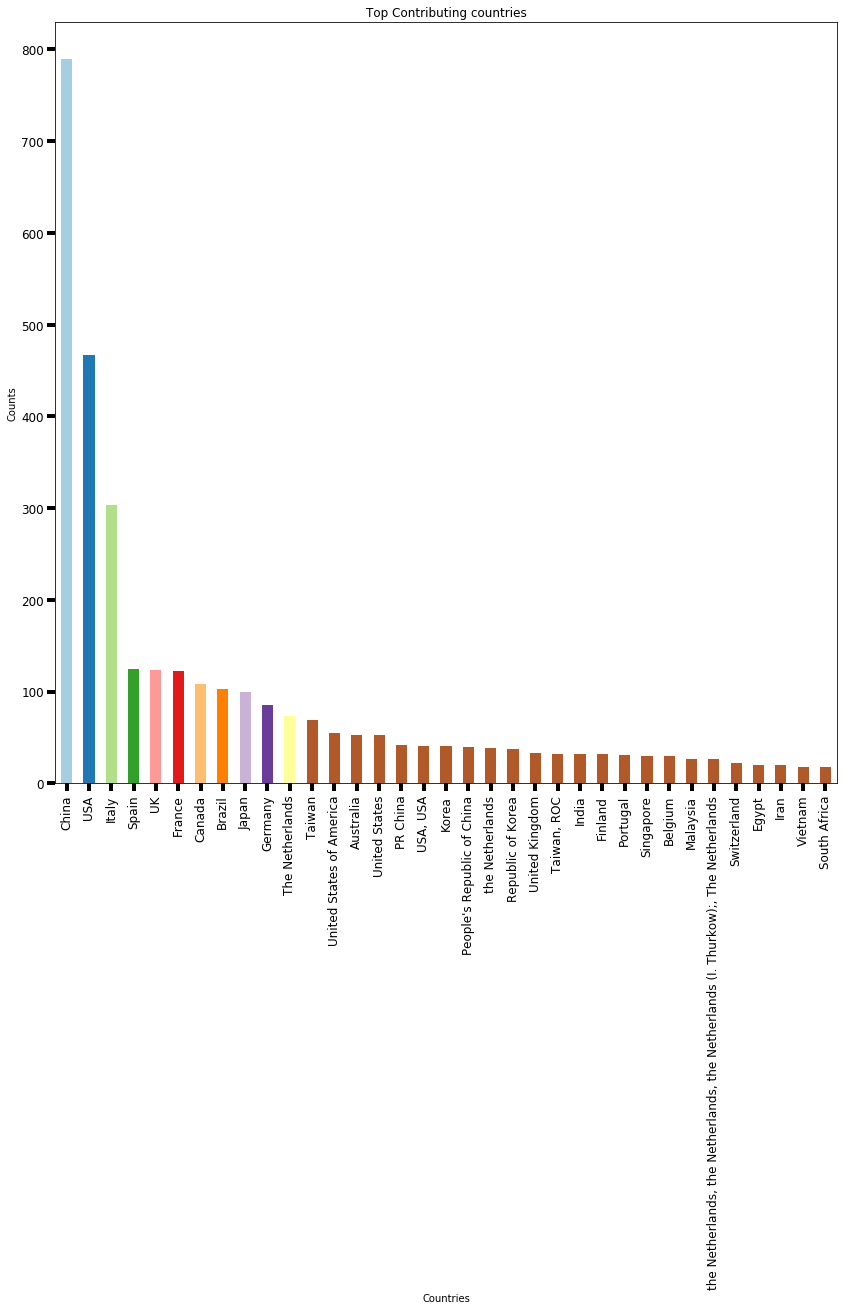

CPU times: user 1.27 s, sys: 31.1 ms, total: 1.3 s
Wall time: 1.35 s


In [73]:
%%time
plot_bars(df=final_dd, groupby='country',top_n=35,
        title='Top Contributing countries', xlabel='Countries', ylabel='Counts')

In [33]:
not_empty_inst=info_dd['institution']!='empty'
clean_info_dd=info_dd[not_empty_inst]
mask2=clean_info_dd['institution']!=''
final_dd=clean_info_dd[mask2]

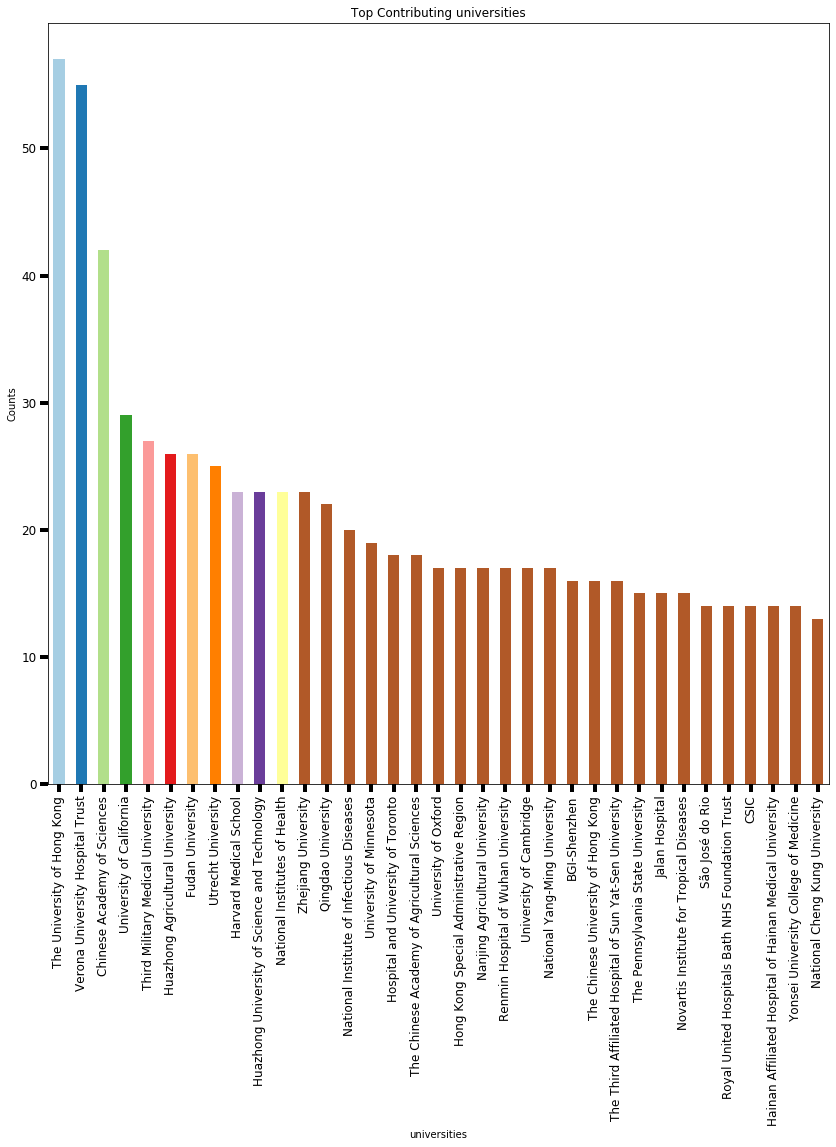

CPU times: user 1.75 s, sys: 149 ms, total: 1.9 s
Wall time: 1.97 s


In [36]:
%%time
plot_bars(df=final_dd, groupby='institution',top_n=35,
        title='Top Contributing universities', xlabel='universities', ylabel='Counts')

# Time Calculations

In [79]:
client=Client()

In [76]:
def calc_time(workers=2, partitions=2):
    # Make cluster
    Cluster = LocalCluster(n_workers=workers)
    # Make client
    client = Client(Cluster) 
    
    # Register start time
    start = time.time() 
    
    # Load data and repartition
    papers_bag1 = db.read_text('data/new_papers/*.json').map(json.loads).repartition(partitions)

    # Algorithm
    text1=papers_bag1.map(flat_bag)
    clean_dicts1=text1.map(text_cleaner)
    all_clean_text1=text1.map(text_cleaner2)
    full_bag1=db.from_sequence(all_clean_text1.fold(add).compute())
    all_counts1=full_bag1.frequencies()
    end = time.time()
    
    # Close client
    client.close()
    # Close cluster
    Cluster.close()
    return end-start

In [77]:
%%time
workers=[2,4,6,8]
partitions=[4,5,10,20]
perms = [(i,j) for i in workers for j in partitions]
print(perms)
registered={}
for i in range(0, len(perms)):
    print(perms[i])
    time_value=calc_time(perms[i][0], perms[i][1])
    registered[perms[i]]=time_value
    print("number of workers:{}".format(perms[i][0]),
          "number of partitions:{}".format(perms[i][1]), 
             "time in second:{}".format(time_value))

[(2, 4), (2, 5), (2, 10), (2, 20), (4, 4), (4, 5), (4, 10), (4, 20), (6, 4), (6, 5), (6, 10), (6, 20), (8, 4), (8, 5), (8, 10), (8, 20)]
(2, 4)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:2 number of partitions:4 time in second:83.41716742515564
(2, 5)
number of workers:2 number of partitions:5 time in second:89.52507090568542
(2, 10)
number of workers:2 number of partitions:10 time in second:90.57211518287659
(2, 20)
number of workers:2 number of partitions:20 time in second:93.96447944641113
(4, 4)
number of workers:4 number of partitions:4 time in second:93.4674916267395
(4, 5)
number of workers:4 number of partitions:5 time in second:79.84771227836609
(4, 10)
number of workers:4 number of partitions:10 time in second:83.12945294380188
(4, 20)
number of workers:4 number of partitions:20 time in second:81.85358715057373
(6, 4)
number of workers:6 number of partitions:4 time in second:74.46867227554321
(6, 5)
number of workers:6 number of partitions:5 time in second:72.77418851852417
(6, 10)
number of workers:6 number of partitions:10 time in second:93.5267984867096
(6, 20)
number of workers:6 number of partitions:20 time in second:82.81074500083923
(

In [78]:
ser1 = pd.Series(list(registered.values()), index=pd.MultiIndex.from_tuples(registered.keys()))
df1 = ser1.unstack().fillna(0)
df1

,4,5,10,20
2,83.417167,89.525071,90.572115,93.964479
4,93.467492,79.847712,83.129453,81.853587
6,74.468672,72.774189,93.526798,82.810745
8,89.780546,84.081870,89.217263,84.670655


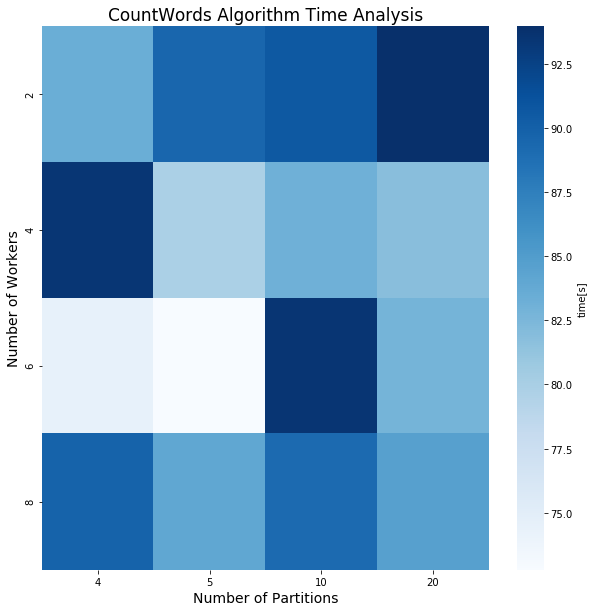

In [95]:
fig, ax= plt.subplots(figsize=(10,10))
title='CountWords Algorithm Time Analysis'
plt.title(title, fontsize=17)
sns.heatmap(df1, cbar_kws={'label': 'time[s]'}, cmap='Blues')
ax.set_xlabel('Number of Partitions', fontsize=14)
ax.set_ylabel('Number of Workers', fontsize=14)
ax2.tick_params(labelsize='10')
plt.show()

In [82]:
def calc_time_countries(workers=2, partitions=2):
    Cluster = LocalCluster(n_workers=workers)
    client = Client(Cluster) 
    # Register start time
    start = time.time() 

    papers_bag2 = db.read_text('data/new_papers/*.json').map(json.loads).repartition(partitions)
    authors1=papers_bag2.pluck('metadata').pluck('authors')
    all_info1=authors1.map(authors_info)
    bag1=all_info1.fold(add_seq).compute()
    info_pd1=pd.DataFrame.from_dict(bag1)
    info_dd1=dd.from_pandas(info_pd1, npartitions=2)
    not_empty=info_dd1['country']!='empty'
    clean_info_dd1=info_dd1[not_empty]
    mask2=clean_info_dd1['country']!=''
    final_dd1=clean_info_dd1[mask2]
    top_25=final_dd1['country'].value_counts().compute()[:25]
    end = time.time()
    
    client.close()
    Cluster.close()
    return end-start

In [83]:
reg_countries={}
for j in range(0, len(perms)):
    print(perms[j])
    time_value1=calc_time_countries(perms[j][0], perms[j][1])
    reg_countries[perms[j]]=time_value1
    print("number of workers:{}".format(perms[j][0]),
          "number of partitions:{}".format(perms[j][1]), 
             "time in seconds:{}".format(time_value1))

(2, 4)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:2 number of partitions:4 time in seconds:23.128092050552368
(2, 5)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:2 number of partitions:5 time in seconds:24.33634090423584
(2, 10)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:2 number of partitions:10 time in seconds:21.81593632698059
(2, 20)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:2 number of partitions:20 time in seconds:25.827760457992554
(4, 4)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:4 number of partitions:4 time in seconds:18.647618293762207
(4, 5)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:4 number of partitions:5 time in seconds:19.320003747940063
(4, 10)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:4 number of partitions:10 time in seconds:16.696763515472412
(4, 20)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:4 number of partitions:20 time in seconds:17.41080141067505
(6, 4)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:6 number of partitions:4 time in seconds:18.496866464614868
(6, 5)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:6 number of partitions:5 time in seconds:17.798994302749634
(6, 10)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:6 number of partitions:10 time in seconds:15.30779480934143
(6, 20)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:6 number of partitions:20 time in seconds:16.058788299560547
(8, 4)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:8 number of partitions:4 time in seconds:18.226088523864746
(8, 5)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:8 number of partitions:5 time in seconds:18.627490758895874
(8, 10)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:8 number of partitions:10 time in seconds:16.232041358947754
(8, 20)


/home/mariam/Downloads/yes/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


number of workers:8 number of partitions:20 time in seconds:18.046866178512573


In [84]:
ser2 = pd.Series(list(reg_countries.values()), index=pd.MultiIndex.from_tuples(reg_countries.keys()))
df2 = ser2.unstack().fillna(0)
df2

,4,5,10,20
2,23.128092,24.336341,21.815936,25.827760
4,18.647618,19.320004,16.696764,17.410801
6,18.496866,17.798994,15.307795,16.058788
8,18.226089,18.627491,16.232041,18.046866


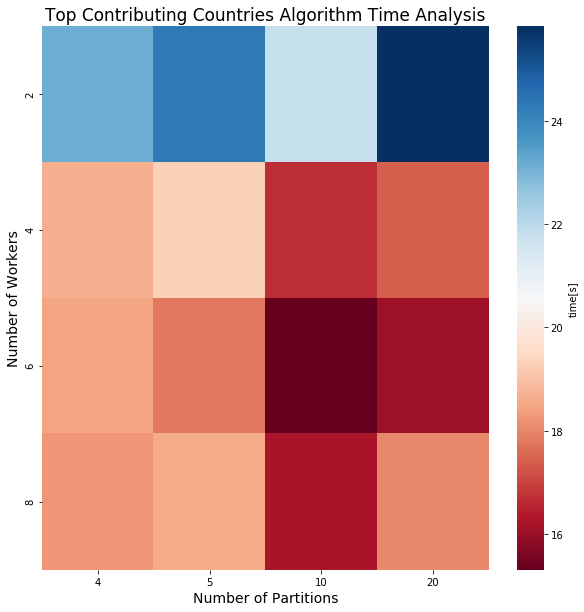

In [104]:
fig2, ax2= plt.subplots(figsize=(10,10))
title='Top Contributing Countries Algorithm Time Analysis'
plt.title(title, fontsize=17)
sns.heatmap(df2, cbar_kws={'label': 'time[s]'}, cmap='RdBu')
ax2.set_xlabel('Number of Partitions', fontsize=14)
ax2.set_ylabel('Number of Workers', fontsize=14)
ax2.tick_params(labelsize='10')
plt.show()

# Embeding

In [5]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [7]:
# def load_wordlist(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     embeddings = np.zeros((n, d), dtype=np.float32)
#     data ={}
#     for i, line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = list(map(float, tokens[1:]))
#     return data
# model = KeyedVectors.load_word2vec_format('./wiki.en.vec')
# #model['hello']

In [ ]:
client = Client()
client

In [ ]:
DB = db.read_text('data/new_papers/*.json').map(json.loads).repartition(npartitions=2)

In [ ]:
def dictionary(record):
    return {
        "paper_id": record['paper_id'],
        "title": record['metadata']['title']
            }

In [ ]:
embeded = DB.map(dictionary).filter(lambda record: bool(record['title'])).compute()